# Training the classifier using Tensorflow
Basis and guide followed: https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-05-02 08:50:12.966754: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 08:50:12.969149: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 08:50:13.001558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 08:50:15.627006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No Bottleneck unit testing available.


In [5]:
import pathlib

data_dir = pathlib.Path('./dataset').with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

124


#### Les images ne doivent pas contenir de 'é' !!

In [82]:
import os

def rename_pictures(directory):
    # Get a list of picture files in the directory
    picture_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Iterate over the picture files and rename them
    for i, filename in enumerate(picture_files, start=40):
        # Construct the new filename
        new_filename = f"capture{i}.jpg"  # Change the extension if necessary
        
        # Rename the file
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))
        print(f"Renamed {filename} to {new_filename}")

# Specify the directory containing the picture files
directory = "./testset/"

# Call the function to rename picture files in the directory
rename_pictures(directory)


Renamed bbc.PNG to capture40.jpg
Renamed carenews.PNG to capture41.jpg
Renamed cnn.PNG to capture42.jpg
Renamed darty.PNG to capture43.jpg
Renamed ebay.PNG to capture44.jpg
Renamed france3.PNG to capture45.jpg
Renamed free.PNG to capture46.jpg
Renamed passport.PNG to capture47.jpg
Renamed stradivarius.PNG to capture48.jpg


## Image pre-processing (using https://www.tensorflow.org/tutorials/load_data/images)
- Modèle de réseau de neuronnes pour classifier selon deux catégories : action forcée présente ou absente
- On redimensionne les images aux dimensions suivantes
- On fait des entraînements par batch de 10

In [7]:
batch_size = 10
img_height = 926
img_width = 1920

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 124 files belonging to 2 classes.
Using 100 files for training.


In [57]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 124 files belonging to 2 classes.
Using 24 files for validation.


### Afficher les classes

In [10]:
class_names = train_ds.class_names
print(class_names)

['absent', 'present']


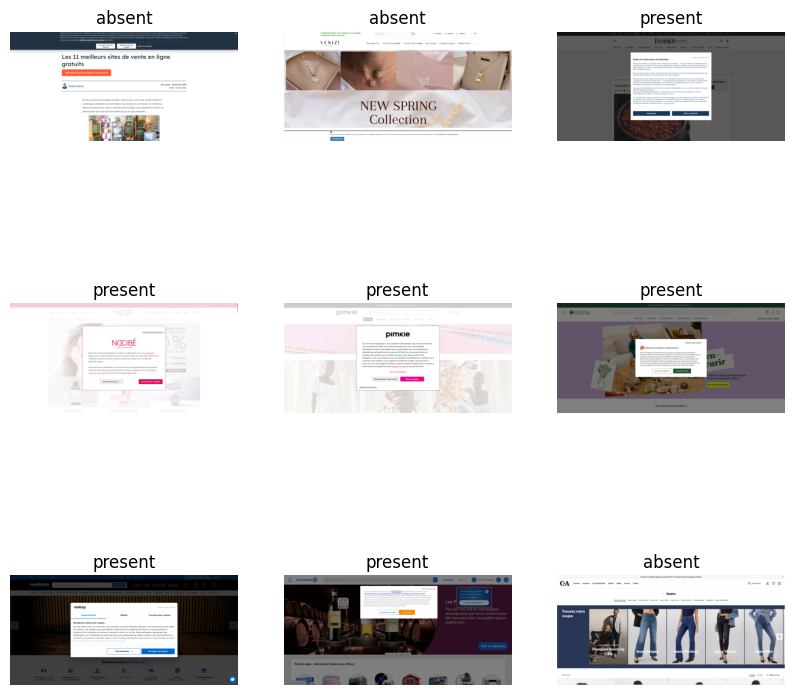

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [60]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 926, 1920, 3)
(10,)


In [61]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [62]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configuring performance

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [65]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
epochs = 3

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step - accuracy: 0.5997 - loss: 27.0671 - val_accuracy: 0.7083 - val_loss: 0.9650
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.6541 - loss: 0.6793 - val_accuracy: 0.7500 - val_loss: 0.5084
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.8577 - loss: 0.3455 - val_accuracy: 0.7917 - val_loss: 0.3780


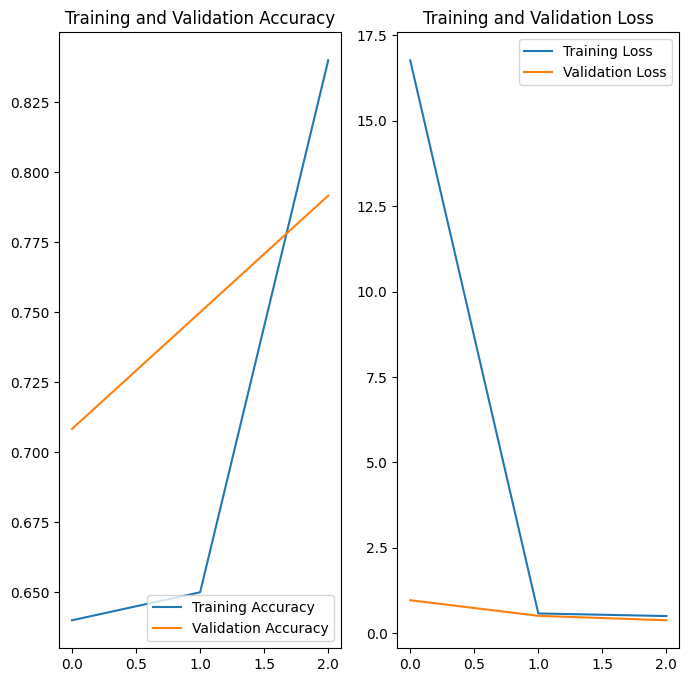

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
model.save('forcedactionmodel.keras')

In [3]:
loaded_model = tf.keras.models.load_model('forcedactionmodel.keras')

2024-05-02 08:50:36.161691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 08:50:36.162210: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
This image most likely belongs to absent with a 76.84 percent confidence.


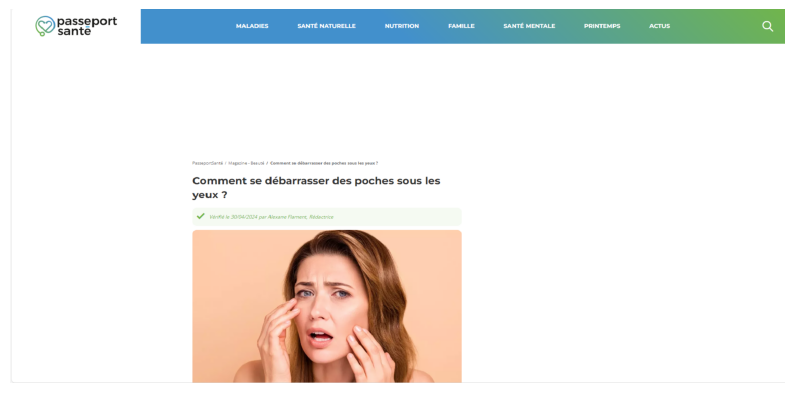

In [16]:
import random

test_dir = pathlib.Path('./testset').with_suffix('')

image_paths = [str(file) for file in test_dir.glob("*.jpg")]

random_picture_path = random.choice(image_paths)

img = tf.keras.utils.load_img(
    random_picture_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

